In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *

d:\Workspace\vinicius\Programs\Miniforge23\envs\diffae\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 1) CHANGE INPUT

#input_folder = 'imgs_interpolate/sandy_dst-crop'
#input_folder = 'imgs_interpolate/profile'
#input_folder = 'imgs_interpolate/profile_flow'
#input_folder = 'imgs_interpolate/smile'
#input_folder = 'imgs_interpolate/glasses'
#input_folder = 'imgs_interpolate/glasses_no_warping'
input_folder = 'imgs_interpolate/profile_flow_new_aligned/'

device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [4]:
data = ImageDataset(input_folder, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = torch.stack([
    data[0]['img'],
    data[1]['img'],
])

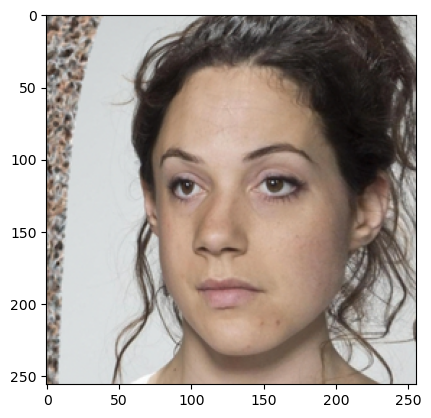

In [5]:
import matplotlib.pyplot as plt
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)

In [6]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


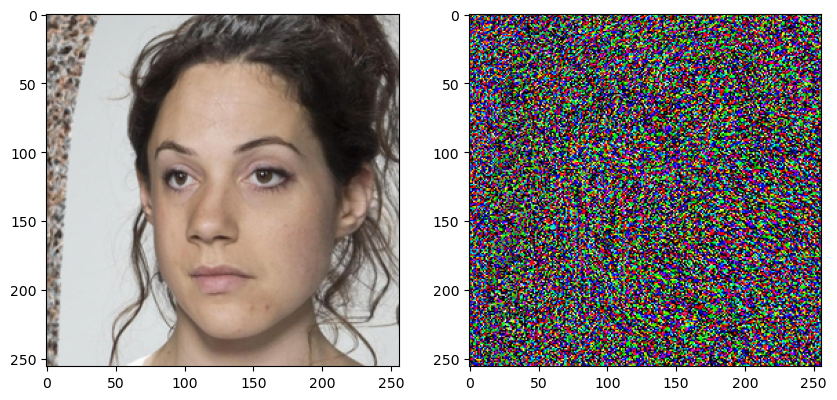

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

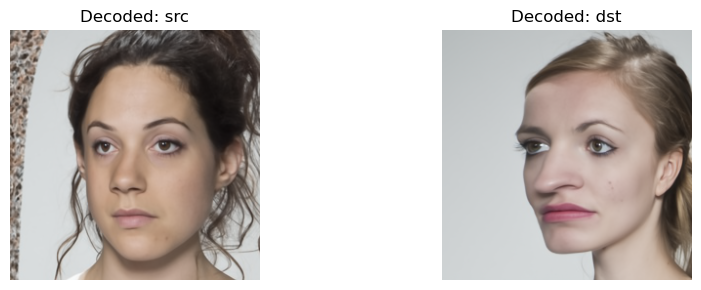

In [8]:
rendered_src = model.render(xT[0].unsqueeze(0), cond[0].unsqueeze(0), T=20)[0]
rendered_dst = model.render(xT[1].unsqueeze(0), cond[1].unsqueeze(0), T=20)[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 3 * 1))

# Handling the single-row case
    
current_axes = [axes[0], axes[1]]

# Plot the Original and Rendered Images Side-by-Side
current_axes[0].imshow(rendered_src.cpu().numpy().transpose(1, 2, 0))
current_axes[0].set_title(f'Decoded: src')
current_axes[0].axis('off')

current_axes[1].imshow(rendered_dst.cpu().numpy().transpose(1, 2, 0))
current_axes[1].set_title(f'Decoded: dst')
current_axes[1].axis('off')

plt.tight_layout()
plt.show()

# Interpolate

Semantic codes are interpolated using convex combination, while stochastic codes are interpolated using spherical linear interpolation.

In [9]:
import numpy as np

# 2) Change the number of frames

N = 75
#N = 5
alpha = torch.tensor(np.linspace(0, 1, N, dtype=np.float32)).to(cond.device)
intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

theta = torch.arccos(cos(xT[0], xT[1]))
x_shape = xT[0].shape
intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
intp_x_1= (1 - alpha[:, None]) * xT[0].flatten(0, 2)[None] + alpha[:, None] * xT[1].flatten(0, 2)[None]

intp_x= 0.1*intp_x_1 +  0.9*intp_x

intp_x = intp_x.view(-1, *x_shape)

pred = model.render(intp_x, intp, T=20)

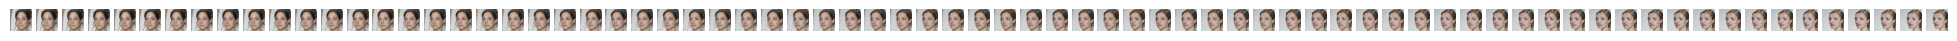

In [10]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, N, figsize=(5*5, 5*5))
for i in range(len(alpha)):
    ax[i].imshow(pred[i].permute(1, 2, 0).cpu())
    ax[i].axis('off')
    # plt.savefig('imgs_manipulated/compare.png')
    im = transforms.ToPILImage()(pred[i])
    #im.save(f"diffae_pure_{i}.png")

In [11]:
from utils import output_video

# 3) Change output video file

#output_video(pred, 'results/diffae_interpolation_tilted_crop.mp4')
output_video(pred, 'results/diffae_interpolation_profile_flow_aligned.mp4')